[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


This follows what we did previously.

In [4]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="openai/gpt-oss-120b",
               api_key=os.getenv("GROQ_API_KEY")
)
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

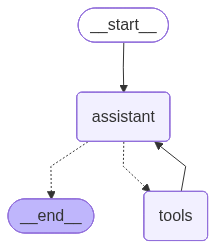

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [7]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_e8b6a4de-857c-4ac2-a1e5-8bd28eb78958)
 Call ID: fc_e8b6a4de-857c-4ac2-a1e5-8bd28eb78958
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Now, let's multiply by 2!

In [8]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

I’m not sure which number you’d like to multiply by 2. Could you please provide the value you’d like me to use?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [10]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_14dd0bc9-b45e-4694-a7a9-fb8c2eccb116)
 Call ID: fc_14dd0bc9-b45e-4694-a7a9-fb8c2eccb116
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_14dd0bc9-b45e-4694-a7a9-fb8c2eccb116)
 Call ID: fc_14dd0bc9-b45e-4694-a7a9-fb8c2eccb116
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_abcdab98-f9e6-420e-89fe-3c0194a7f523)
 Call ID: fc_abcdab98-f9e6-420e-89fe-3c0194a7f523
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =============

## LangGraph Studio


**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

```
langgraph dev
```

*I asked to multiply 4 and 5 first:*

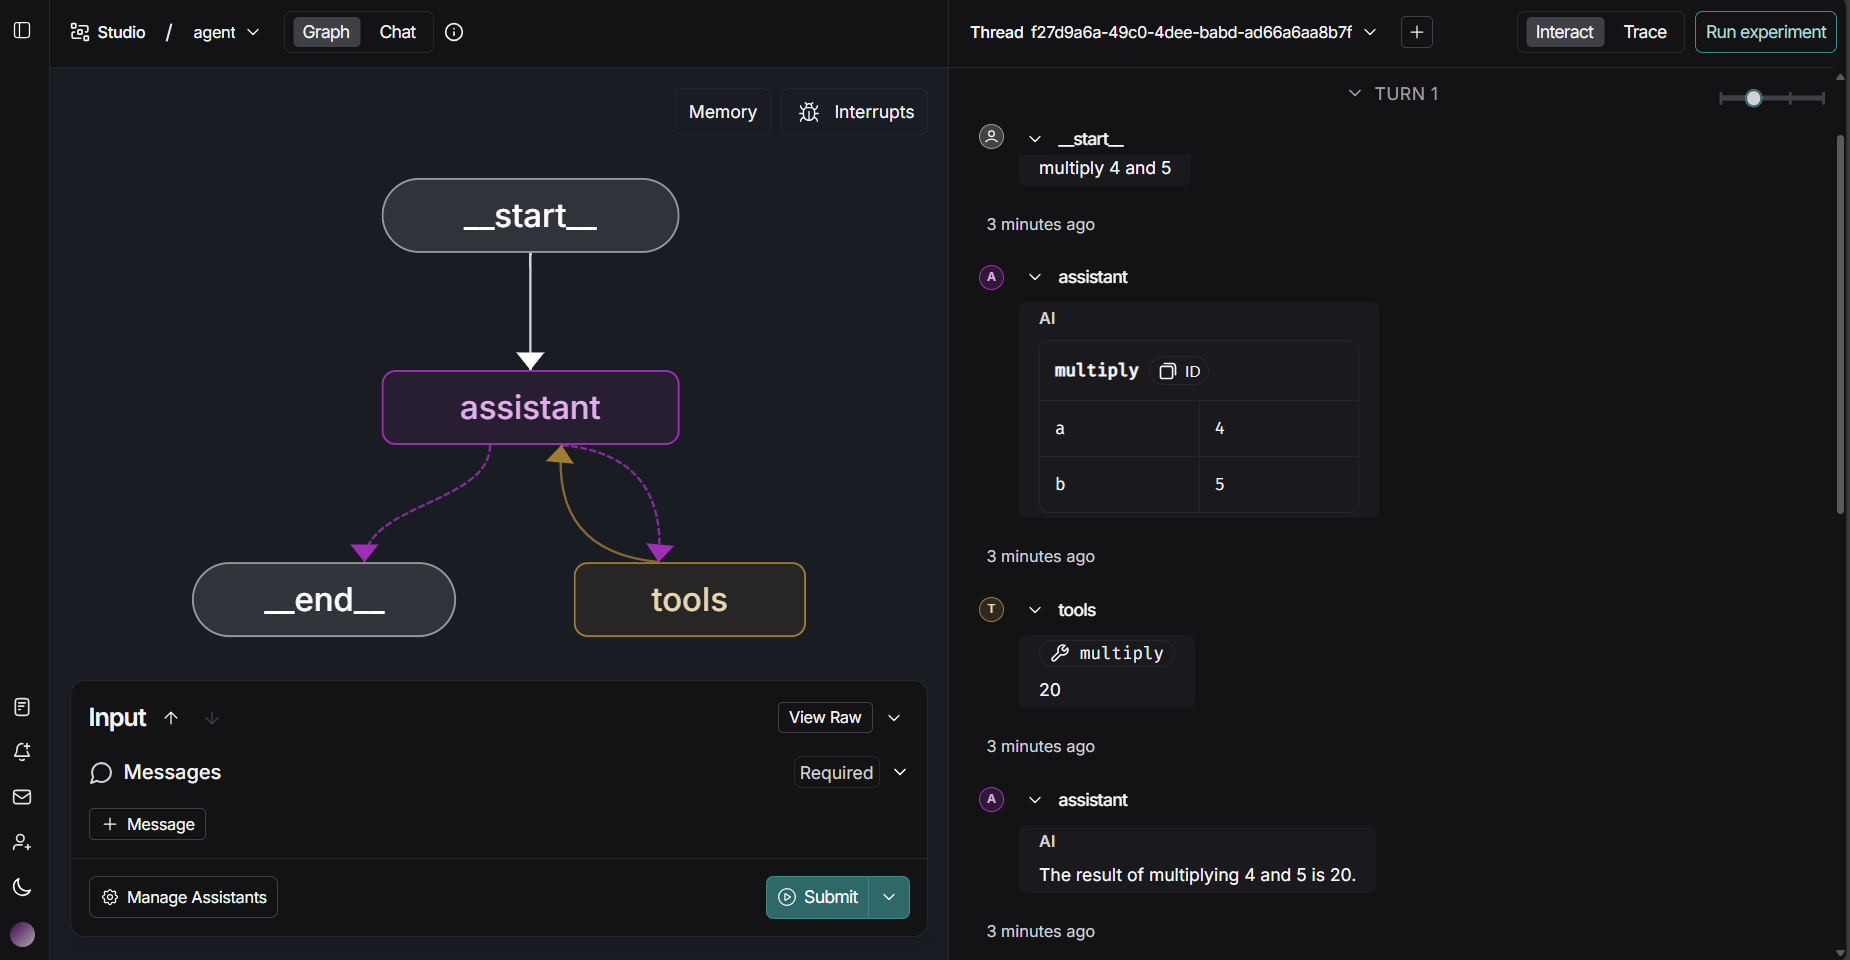

*then i said to add 8 to the output:*

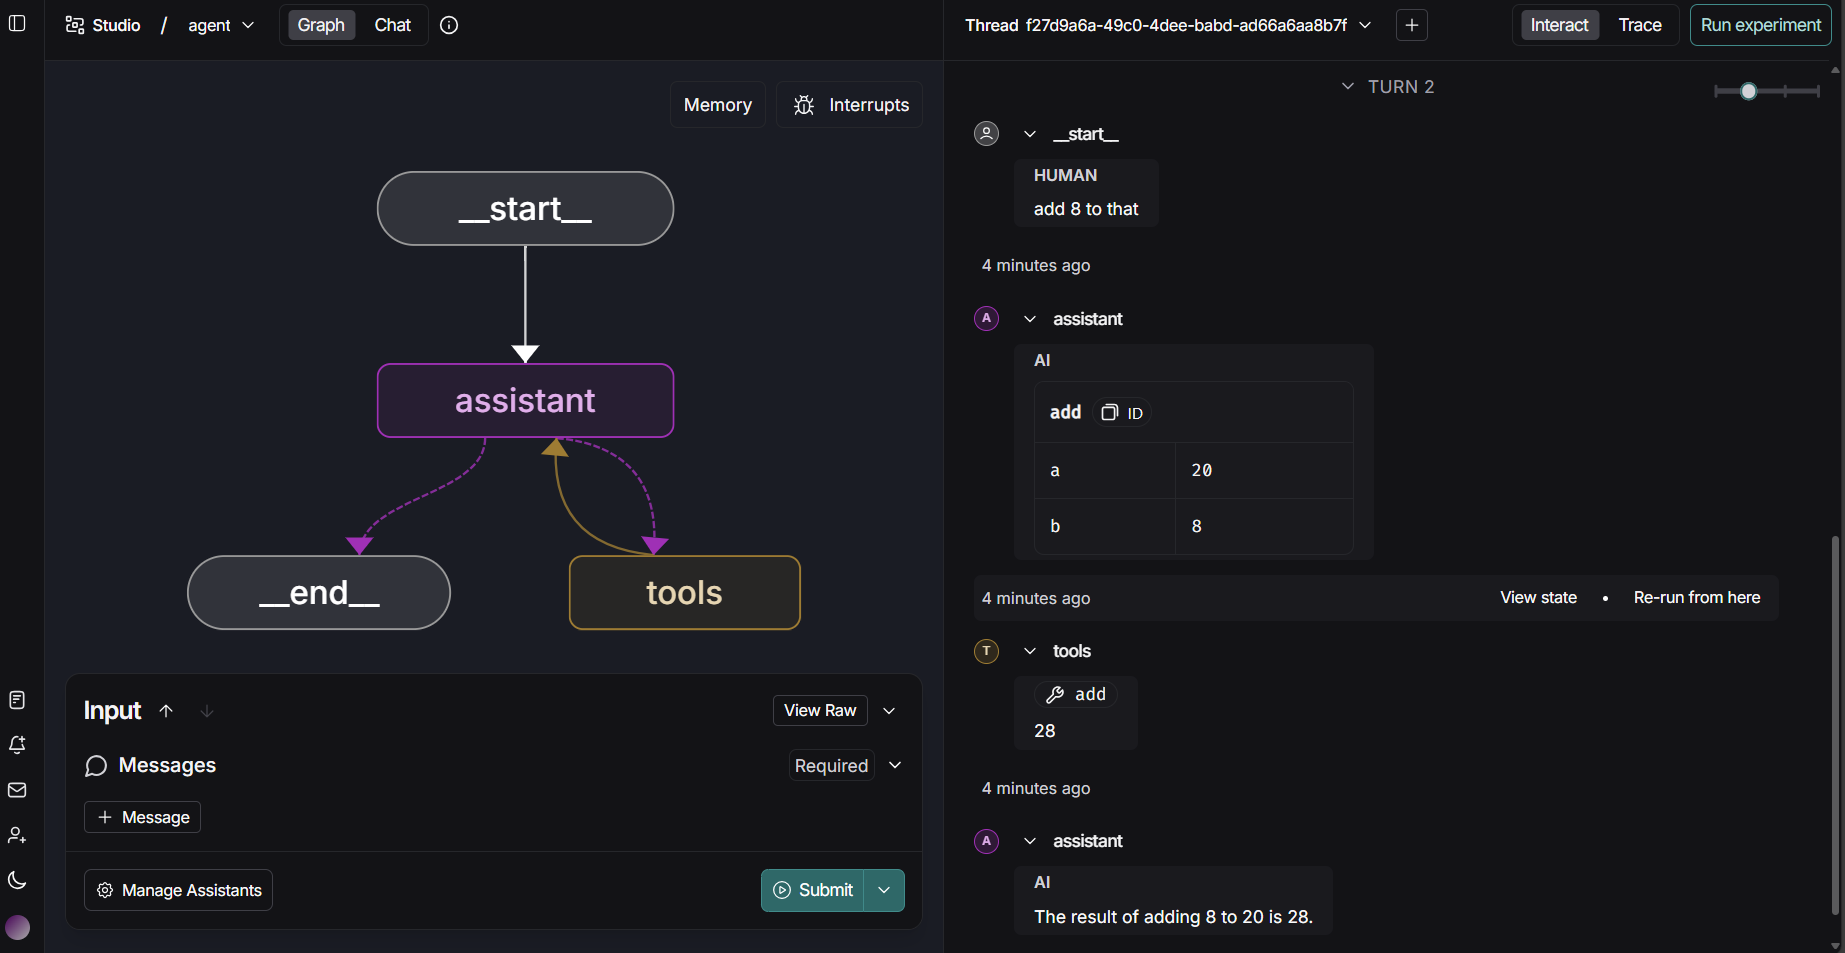

# MY EXAMPLES:

Create a new set of Python functions that will serve as the tools for the new agent.


In [12]:
def power(base: int, exponent: int) -> int:
    """Raise base to the power of exponent.

    Args:
        base: The base number.
        exponent: The exponent.
    """
    return base ** exponent

def sqrt(number: int) -> float:
    """Calculate the square root of a number.

    Args:
        number: The number.
    """
    return number ** 0.5

def modulus(a: int, b: int) -> int:
    """Calculate the remainder of the division of a by b.

    Args:
        a: The dividend.
        b: The divisor.
    """
    return a % b

new_tools = [power, sqrt, modulus]

Bind the new tools to the Language Model.


In [13]:
llm_with_tools = llm.bind_tools(new_tools)

Construct a new LangGraph StateGraph with the defined nodes and edges, similar to the previous example, but using the new tools.


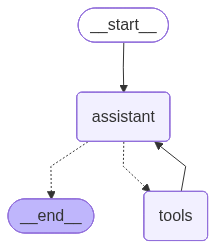

In [15]:
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(new_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph_new_tools = builder.compile()

# Show
display(Image(react_graph_new_tools.get_graph(xray=True).draw_mermaid_png()))

Compile the new graph with a MemorySaver checkpointer to enable persistence.


In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory_new = MemorySaver()
react_graph_memory_new_tools = builder.compile(checkpointer=memory_new)

Invoke the new graph with an input message and a thread ID to demonstrate its memory capabilities with the new tools.


In [24]:
config_new = {"configurable": {"thread_id": "new_thread"}}

messages_new = [HumanMessage(content="Calculate 5 to the power of 3.")]

messages_new = react_graph_memory_new_tools.invoke({"messages": messages_new}, config_new)
for m in messages_new['messages']:
    m.pretty_print()

================================ Human Message =================================

Calculate 5 to the power of 3.
================================== Ai Message ==================================
Tool Calls:
  power (fc_79e017ec-1f40-460b-89d4-2876dd7498d5)
 Call ID: fc_79e017ec-1f40-460b-89d4-2876dd7498d5
  Args:
    base: 5
    exponent: 3
================================= Tool Message =================================
Name: power

125
================================== Ai Message ==================================

The result of \(5^3\) is **125**.


In [25]:
messages_new_follow_up = [HumanMessage(content="Now, find the square root of that result.")]

messages_new = react_graph_memory_new_tools.invoke({"messages": messages_new_follow_up}, config_new)
for m in messages_new['messages']:
    m.pretty_print()

================================ Human Message =================================

Calculate 5 to the power of 3.
================================== Ai Message ==================================
Tool Calls:
  power (fc_79e017ec-1f40-460b-89d4-2876dd7498d5)
 Call ID: fc_79e017ec-1f40-460b-89d4-2876dd7498d5
  Args:
    base: 5
    exponent: 3
================================= Tool Message =================================
Name: power

125
================================== Ai Message ==================================

The result of \(5^3\) is **125**.
================================ Human Message =================================

Now, find the square root of that result.
================================== Ai Message ==================================
Tool Calls:
  sqrt (fc_e4e2f981-f532-4084-9e7e-2fde45db3ff8)
 Call ID: fc_e4e2f981-f532-4084-9e7e-2fde45db3ff8
  Args:
    number: 125
================================= Tool Message =================================
Name: sqrt

11.18033988

### *In LangGraph Studio:*

*First I asked what is 6^7 :*

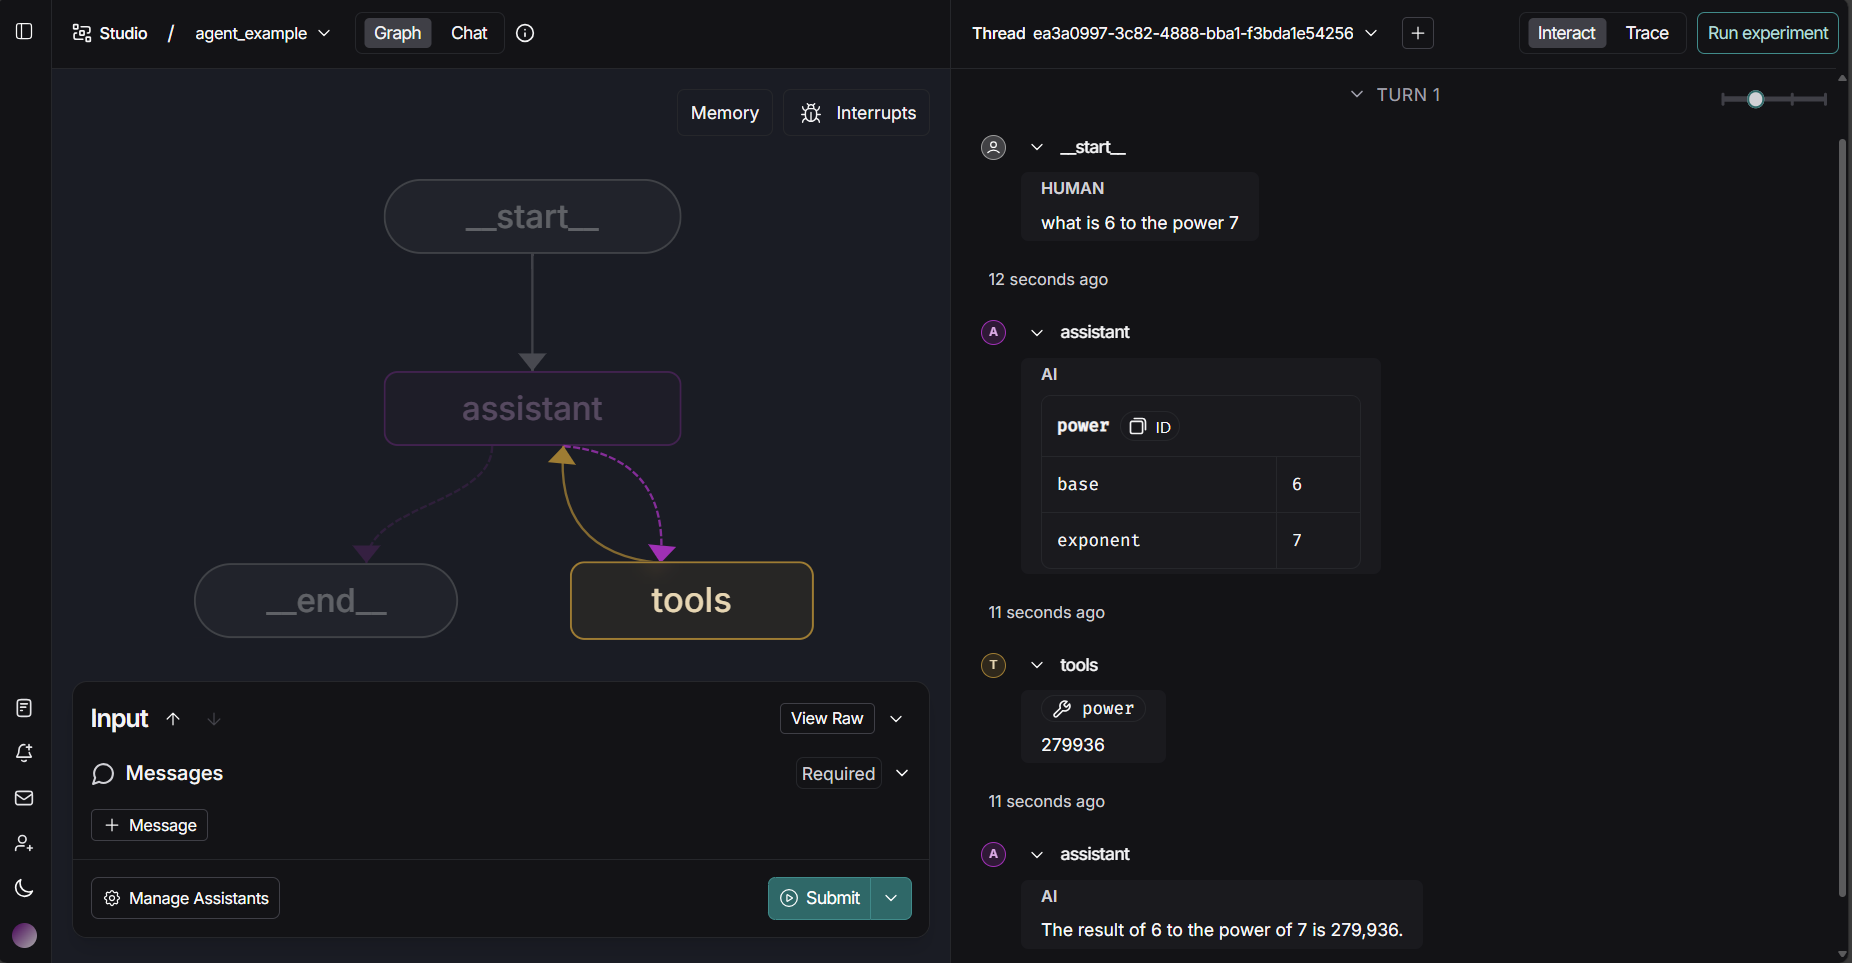

*Then I told to do square root of that :*

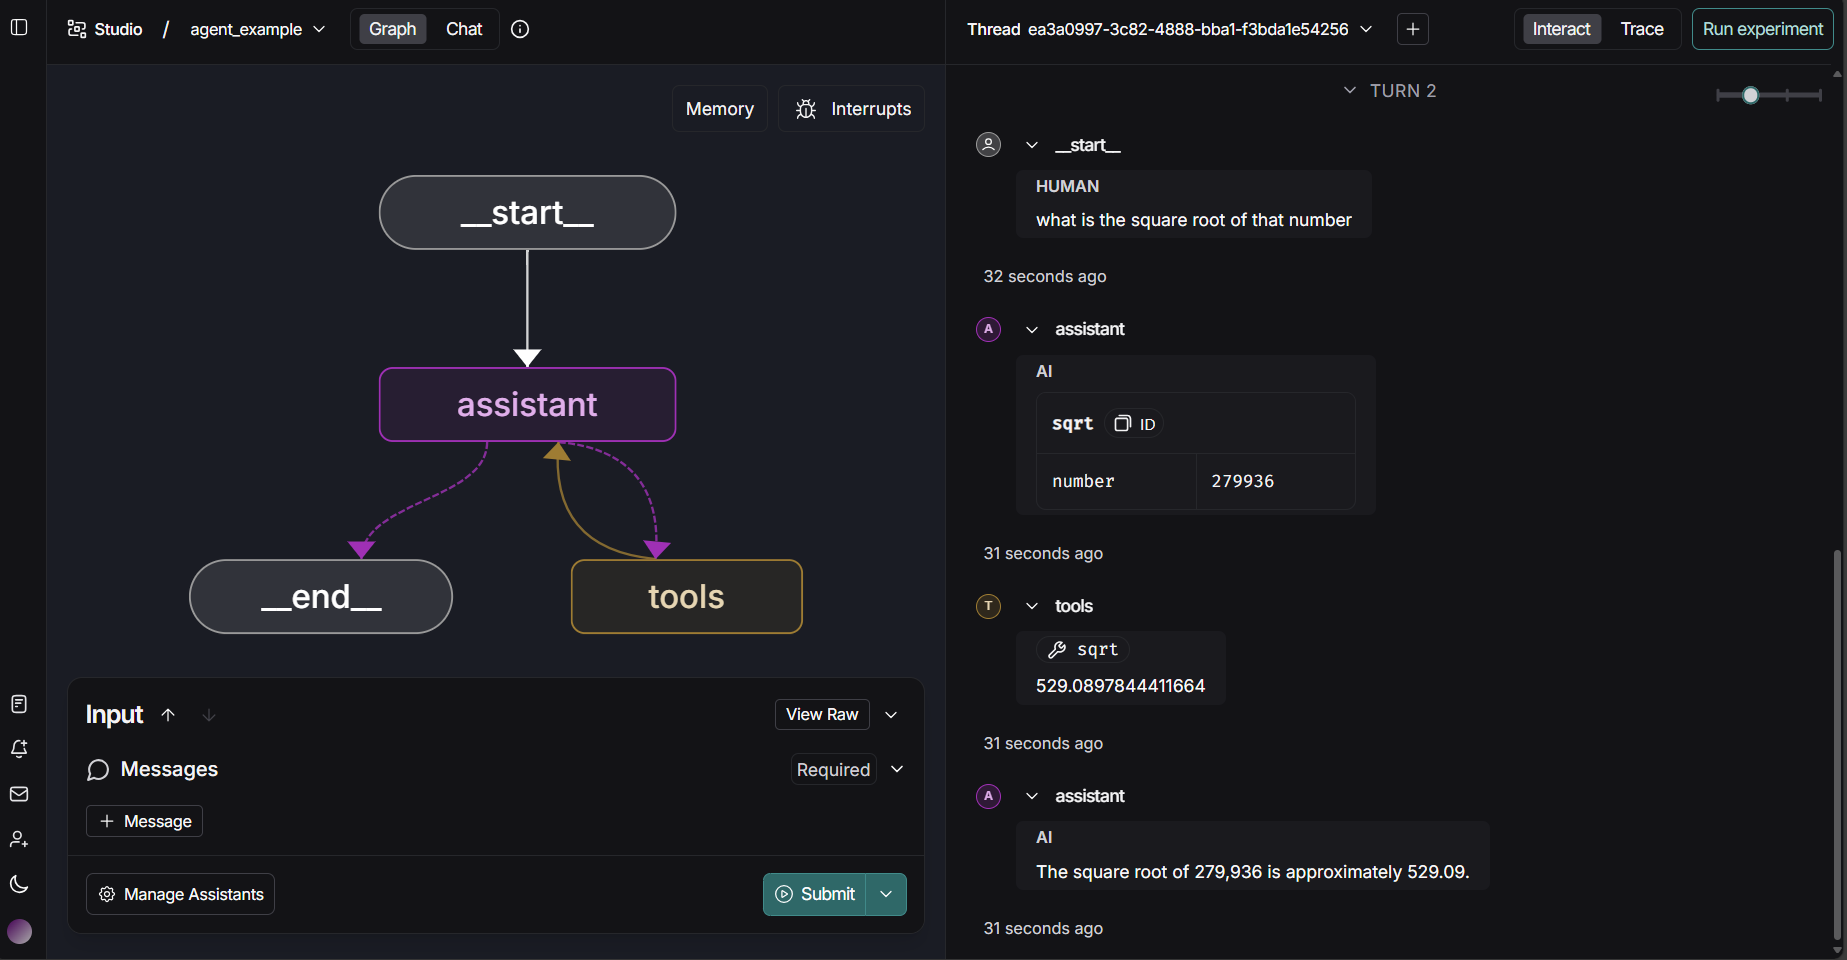